In [2]:
! pip install ydata-synthetic

In [7]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [9]:
#Specific to TimeGANs
seq_len=6
n_seq = 6
hidden_dim=12
gamma=1

noise_dim = 8
dim = 64
batch_size = 64

log_step = 25
learning_rate = 5e-4

gan_args = [batch_size, learning_rate, noise_dim, 6, 2, (0, 1), dim]

In [10]:
stock_data = processed_stock(seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

245 (6, 6)


In [11]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=12, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=10000)
    synth.save('synthesizer_stock.pkl')

EOFError: 

In [6]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

NameError: name 'synth' is not defined

NameError: name 'stock_data' is not defined

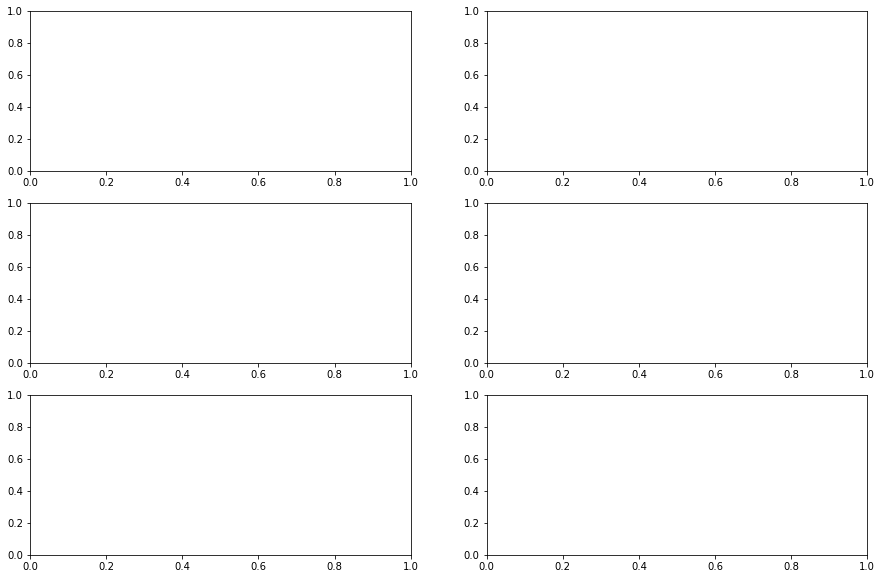

In [5]:
#Reshaping the data
cols = ['Open','High','Low','Close','Adj Close', 'Volume']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

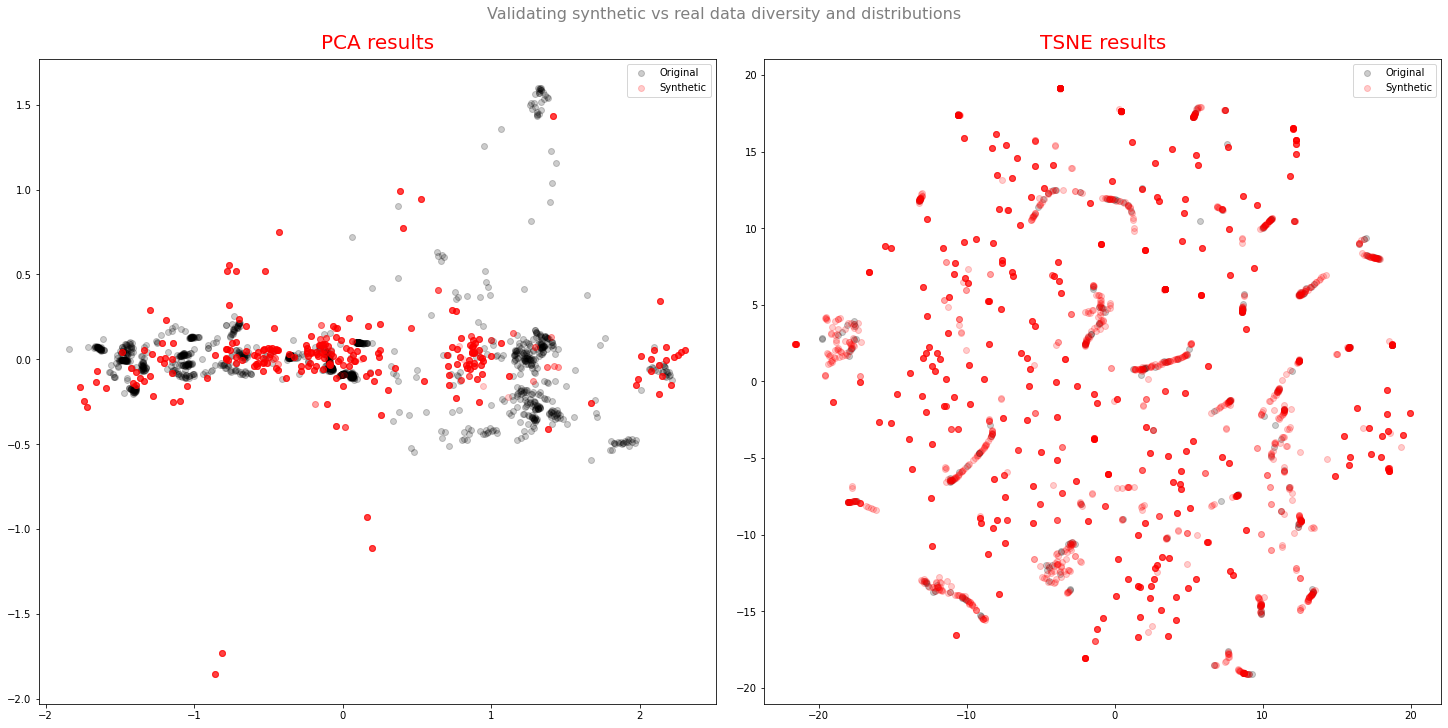

In [33]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

In [38]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [42]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (183, 5, 6)
Real X train: (183, 5, 6)
Synthetic y train: (183, 6)
Real y train: (183, 6)
Real X test: (62, 5, 6)
Real y test: (62, 6)


In [43]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
2/2 [==============================] - 2s 285ms/step - loss: 0.2212 - val_loss: 0.1820
Epoch 2/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2159 - val_loss: 0.1806
Epoch 3/200
2/2 [==============================] - 0s 40ms/step - loss: 0.2150 - val_loss: 0.1791
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2146 - val_loss: 0.1777
Epoch 5/200
2/2 [==============================] - 0s 38ms/step - loss: 0.2114 - val_loss: 0.1763
Epoch 6/200
2/2 [==============================] - 0s 37ms/step - loss: 0.2144 - val_loss: 0.1750
Epoch 7/200
2/2 [==============================] - 0s 36ms/step - loss: 0.2122 - val_loss: 0.1736
Epoch 8/200
2/2 [==============================] - 0s 34ms/step - loss: 0.2100 - val_loss: 0.1723
Epoch 9/200
2/2 [==============================] - 0s 37ms/step - loss: 0.2040 - val_loss: 0.1710
Epoch 10/200
2/2 [==============================] - 0s 39ms/step - loss: 0.2029 - val_loss: 0.1697
Epoch 11/200
2/2 [

Epoch 84/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1061 - val_loss: 0.0839
Epoch 85/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1057 - val_loss: 0.0835
Epoch 86/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1054 - val_loss: 0.0832
Epoch 87/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1012 - val_loss: 0.0827
Epoch 88/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1057 - val_loss: 0.0822
Epoch 89/200
2/2 [==============================] - 0s 44ms/step - loss: 0.1053 - val_loss: 0.0816
Epoch 90/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1015 - val_loss: 0.0811
Epoch 91/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1026 - val_loss: 0.0807
Epoch 92/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1047 - val_loss: 0.0805
Epoch 93/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1006 - val_loss: 0.0804
Epoch 94/2

In [45]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
2/2 [==============================] - 1s 242ms/step - loss: 0.2025 - val_loss: 0.1732
Epoch 2/200
2/2 [==============================] - 0s 38ms/step - loss: 0.2017 - val_loss: 0.1723
Epoch 3/200
2/2 [==============================] - 0s 39ms/step - loss: 0.1976 - val_loss: 0.1714
Epoch 4/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2017 - val_loss: 0.1704
Epoch 5/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1984 - val_loss: 0.1696
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1950 - val_loss: 0.1687
Epoch 7/200
2/2 [==============================] - 0s 38ms/step - loss: 0.1949 - val_loss: 0.1680
Epoch 8/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1939 - val_loss: 0.1672
Epoch 9/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1933 - val_loss: 0.1664
Epoch 10/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1931 - val_loss: 0.1656
Epoch 11/200
2/2 [

In [46]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

r2       MAE      MRLE
Real       0.524759  0.078037  0.008310
Synthetic  0.521514  0.077845  0.008411